In [ ]:
# MLP(Multi-Layer Perceptron) - 필기체손글씨 MNIST Dataset

# 딥러닝 MLP 아키텍처
# - 학습데이터 -> 입력층>은닉층>ReLU>Dropout>출력층>Softmax -> 손실함수

# 입력층
# - (28,28) 크기를 가지는 2차원 이미지를 784개(28x28)의 길이를 갖는 1차원 벡터로 변환해서 은닉층으로 전달
# 은닉층
# - 일반적으로 1개 이상의 은닉층으로 이루어지며 각각의 은닉층은 내부에 많은 노드(node)로 구성
# - 은닉층 개수과 노드 개수는 학습데이터와 성능을 고려하여 최적의 값을 찾아야 하는 하이퍼 파라미터
# ReLU
# - 활성화함수로서 입력값이 0보다 크면 입력값 그대로 내보내고, 0보다 작으면 0을 출력하는 비선형함수
# Dropout
# - 학습데이터에 대해 과적합(overfitting)을 줄이기 위해 신경망 뉴런을 주어진 확률값에 따라 부분적으로 제거(drop)해주는 함수
# 출력층
# - 출력층 노드 개수는 정답(label) 개수와 같은 10개로 설정
# - 학습데이터의 정답은 0~9까지 총 10개 가운데 하나의 숫자로 표현되기 때문에 출력층 노드 개수가 또한 정답 개수와 동일한 10개
# Softmax
# - 다중 클래스 분류 모델을 만들때 사용
# - 입력된 벡터의 각 요소를 0~1 사이의 확률값으로 변환해주는 함수

# Confusion Matrix와 Classification Report를 추가해서 모델의 예측 성능을 클래스별로 분석
# 오차 분석 및 시각화
# 이 코드는 테스트 데이터셋을 순회하면서:
# - 모델이 틀린 예측을 한 샘플만 골라
# - 이미지, 정답, 예측값을 각각 리스트에 저장
# - 지정한 개수만큼 수집되면 종료
# 이후 이 리스트들을 시각화하면 오차 분석용 이미지 갤러리가 완성된다.


In [52]:
# 1) 라이브러리, GPU 설정
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.8.0+cpu , device :  cpu


In [26]:
# 2) MNIST Dataset 다운로드
train_dataset = datasets.MNIST(root='./data/MNIST_data',
                               train=True, # train
                               transform=transforms.ToTensor(), # 이미지 픽셀값 0~255까지의 값을 0~1 사이의 값을 변환
                               download=True)

test_dataset = datasets.MNIST(root='./data/MNIST_data',
                               train=False, # test
                               transform=transforms.ToTensor(),
                               download=True)

In [27]:
# 데이터 확인
print(len(train_dataset), len(test_dataset))

60000 10000


In [28]:
# 3) MNIST Dataset을 train/validation 분할(train : validation = 85% : 15%)
train_dataset_size = int(len(train_dataset) * 0.85) # train 85%
validation_dataset_size = int(len(train_dataset) * 0.15) # validation 15%
train_dataset, validation_dataset = random_split(dataset=train_dataset,
                                                 lengths=[train_dataset_size, validation_dataset_size])

In [29]:
# 분리된 데이터 확인
print(len(train_dataset), len(validation_dataset), len(test_dataset))

51000 9000 10000


In [30]:
# 4) batch, Dataloader 생성
BATCH_SIZE = 32

train_dataset_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)

validation_dataset_loader = DataLoader(dataset=validation_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

test_dataset_loader = DataLoader(dataset=test_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


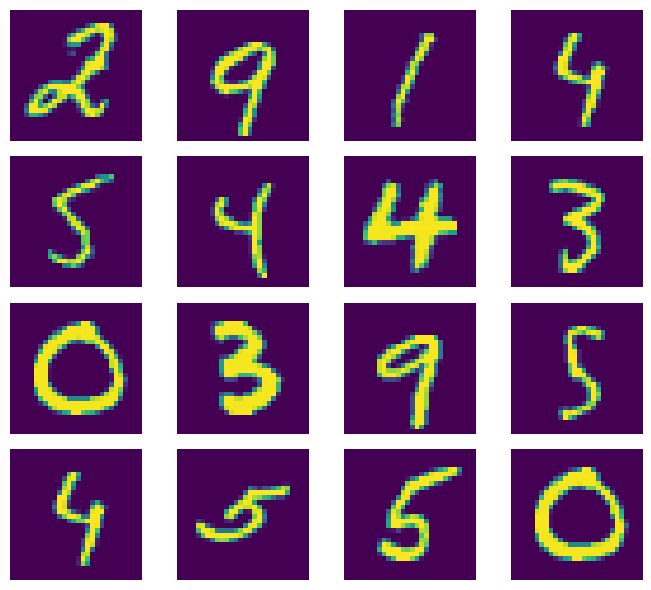

In [31]:
# 5) MNIST Dataset 1개 배치 데이터 확인
images, labels = next(iter(train_dataset_loader))

# labels map 생성
labels_map = { v:k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

plt.figure(figsize=(7,6))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    # len(images) 현재 배치에 포함된 이미지 수(보통 BATCH_SIZE 크기), torch.randint(len(images), size=(1,)) 0부터 a-1까지의 정수 중 하나를 랜덤으로 선택, .item() 텐서에서 단일 값을 추출하여 파이썬 숫자형으로 변환
    # images가 32개의 이미지로 구성된 배치라면, len(images) -> 32, torch.randint(32, size=(1,)) -> 17, .item() -> 17(정수로 변환), 즉 sample_idx=17 이 되어, 32개 이미지 중 17번째 이미지를 선택하게 된다.
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    
    plt.subplot(cols, rows, i)
    plt.imshow(torch.permute(img, (1,2,0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [32]:
# 6) MLP Model
class MLPDeepLearningModel(nn.Module):
    # model 정의 - 아키텍처를 구성하는 다양한 계층(layer)을 정의
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x) # 입력층
        x = self.fc1(x) # 은닉층
        x = self.relu(x) # 활성화함수 ReLU(비선형함수)
        x = self.dropout(x) # overfitting 방지
        x = self.fc2(x) # 출력층
        return x

In [33]:
# 7) Model 객체 생성
model = MLPDeepLearningModel().to(DEVICE)

# loss function, CrossEntropyLoss 손실함수에는 Softmax 함수 포함되어 있음
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [34]:
# 8) Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
        x_train = images.view(-1, 28 * 28).to(DEVICE)
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()
        train_total += y_train.size(0) # BATCH_SIZE=32 현재 배치가 32개, y_train.size(0) -> 32, train_total +=32 누적된 학습 샘플 수가 32씩 증가, 참고로 size(0) 텐서의 첫번째 차원의 크기 즉 배치의 샘플수 32
        # 하기 코드 예시) outputs = tensor([
        # [0.1, 0.2, 0.7, ..., 0.0],  # 예측: class 2
        # [0.9, 0.05, 0.01, ..., 0.0], # 예측: class 0
        # [0.1, 0.3, 0.6, ..., 0.0],  # 예측: class 2
        # [0.05, 0.9, 0.02, ..., 0.0] # 예측: class 1
        # ])
        # y_train = tensor([2, 0, 1, 1])  # 실제 정답
        # 예측 결과
        # preds = torch.argmax(outputs, 1)  # tensor([2, 0, 2, 1])
        # 비교 결과
        # correct = (preds == y_train)      # tensor([True, True, False, True])
        # 맞춘 개수
        # correct.sum().item()              # 3
        train_correct += (torch.argmax(outputs, 1) == y_train).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [35]:
# 9) Model evaluate 함수
def model_evaluate(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_val = images.view(-1, 28 * 28).to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, 1) == y_val).sum().item()
        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [44]:
# 10) Model test 함수
def model_test(dataloader, model):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)

        all_preds = []
        all_labels = []

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_test = images.view(-1, 28 * 28).to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)
            _, preds = torch.max(outputs, 1)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, 1) == y_test).sum().item()

            all_preds.extend(preds.cpu().numpy()) # 예측값
            all_labels.extend(y_test.cpu().numpy()) # 정답값

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)

        # Confusion Matrix - Confusion Matrix: 각 숫자 클래스별로 얼마나 잘 맞췄는지 시각적으로 확인 가능
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

        # Classification Report - precision(예측한 것 중에 실제로 맞춘 비율), recall(실제 정답 중에 얼마나 맞췄는지), f1-score(precision과 recall의 조화 평균), support(각 클래스의 샘플 수)
        report = classification_report(all_labels, all_preds, digits=4)
        print('classification report:\n', report)


In [47]:
# 11) 오차 분석 시각화 코드
# 이 코드는 테스트 데이터셋을 순회하면서:
# - 모델이 틀린 예측을 한 샘플만 골라
# - 이미지, 정답, 예측값을 각각 리스트에 저장
# - 지정한 개수만큼 수집되면 종료
# 이후 이 리스트들을 시각화하면 오차 분석용 이미지 갤러리가 완성된다.

def visualize_misclassified_samples(model, dataloader, num_samples=16):
    model.eval() # 추론 모드
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            x = images.view(-1, 28 * 28).to(DEVICE) # 학습데이터
            y = labels.to(DEVICE) # 정답데이터

            outputs = model(x) # 모델 에측값
            # 하기 코드 예시) outputs = tensor([
            # [0.1, 0.2, 0.7, ..., 0.0],  # 예측: class 2
            # [0.9, 0.05, 0.01, ..., 0.0], # 예측: class 0
            # ])
            # torch.max(outputs, 1) -> (tensor( [0.7, 0.9] ), tensor( [2, 0] ))
            _, preds = torch.max(outputs, 1) # preds 최대값의 인덱스 → 모델이 예측한 클래스 번호, _ 최대값 자체 (확률 또는 점수), 여기선 사용하지 않으므로 생략, dim=1 열 방향 즉 클래스별 비교를 의미

            # 틀린 예측만 필터링
            mis_idx = (preds != y).cpu().numpy() # preds != y - 예측값과 실제값이 다른 위치를 True로 표시하는 불리언 텐서,.cpu().numpy() GPU 텐서를 CPU로 옮기고 넘파이 배열로 변환, 결과: [False, True, False, True, ...] 형태의 배열 → 틀린 샘플만 True
            misclassified_images.extend(images[mis_idx]) # 틀린 예측을 한 이미지들만 선택, extend() 리스트에 여러 이미지 추가
            misclassified_labels.extend(y.cpu().numpy()[mis_idx]) # 틀린 예측에 해당하는 라벨만 선택, 정답 라벨을 넘파이 배열로 변환
            misclassified_preds.extend(preds.cpu().numpy()[mis_idx]) # 틀린 예측값

            # 너무 많은 틀린 샘플을 저장하지 않도록 num_samples 개수만큼만 수집, 예시) num_samples = 16이면 16개까지만 저장하고 반복 종료
            if len(misclassified_images) >= num_samples:
                break
    
    # 시각화
    plt.figure(figsize=(10, 9))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        img = misclassified_images[i].squeeze()
        true_label = misclassified_labels[i]
        pred_label = misclassified_preds[i]

        plt.imshow(img, cmap='gray')
        plt.title(f'True: {true_label}, Pred: {pred_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# 12) Model 학습
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy)
    )

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

epoch :  01 train loss =  0.977935 , train acc =  76.954902 val loss =  0.470860 , val acc =  87.633333
epoch :  02 train loss =  0.436539 , train acc =  87.774510 val loss =  0.361917 , val acc =  89.622222
epoch :  03 train loss =  0.366927 , train acc =  89.607843 val loss =  0.320014 , val acc =  90.866667
epoch :  04 train loss =  0.326746 , train acc =  90.621569 val loss =  0.290509 , val acc =  91.522222
epoch :  05 train loss =  0.296377 , train acc =  91.600000 val loss =  0.266409 , val acc =  92.166667
epoch :  06 train loss =  0.273200 , train acc =  92.231373 val loss =  0.247595 , val acc =  92.733333
epoch :  07 train loss =  0.254365 , train acc =  92.825490 val loss =  0.230289 , val acc =  93.144444
epoch :  08 train loss =  0.237819 , train acc =  93.229412 val loss =  0.216097 , val acc =  93.633333
epoch :  09 train loss =  0.224517 , train acc =  93.633333 val loss =  0.204644 , val acc =  94.055556
epoch :  10 train loss =  0.210388 , train acc =  94.070588 val 

accuracy =  96.42 , loss =  0.12244990529505886


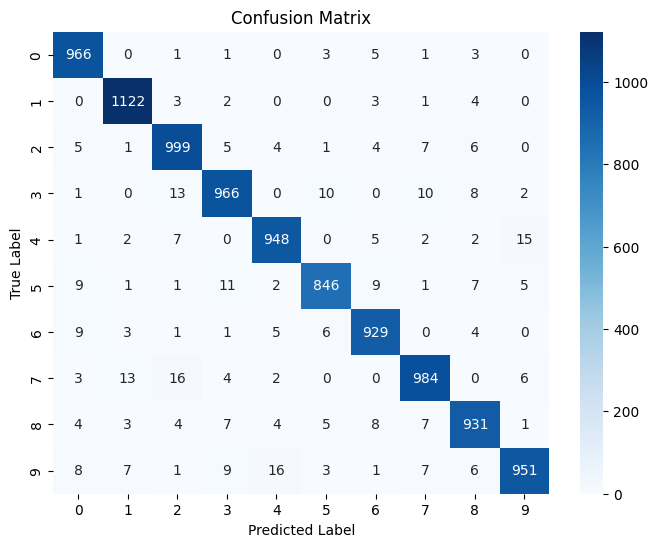

classification report:
               precision    recall  f1-score   support

           0     0.9602    0.9857    0.9728       980
           1     0.9740    0.9885    0.9812      1135
           2     0.9551    0.9680    0.9615      1032
           3     0.9602    0.9564    0.9583      1010
           4     0.9664    0.9654    0.9659       982
           5     0.9680    0.9484    0.9581       892
           6     0.9637    0.9697    0.9667       958
           7     0.9647    0.9572    0.9609      1028
           8     0.9588    0.9559    0.9573       974
           9     0.9704    0.9425    0.9563      1009

    accuracy                         0.9642     10000
   macro avg     0.9641    0.9638    0.9639     10000
weighted avg     0.9642    0.9642    0.9642     10000



In [ ]:
# 13) Test Dataset 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader,
            model=model)

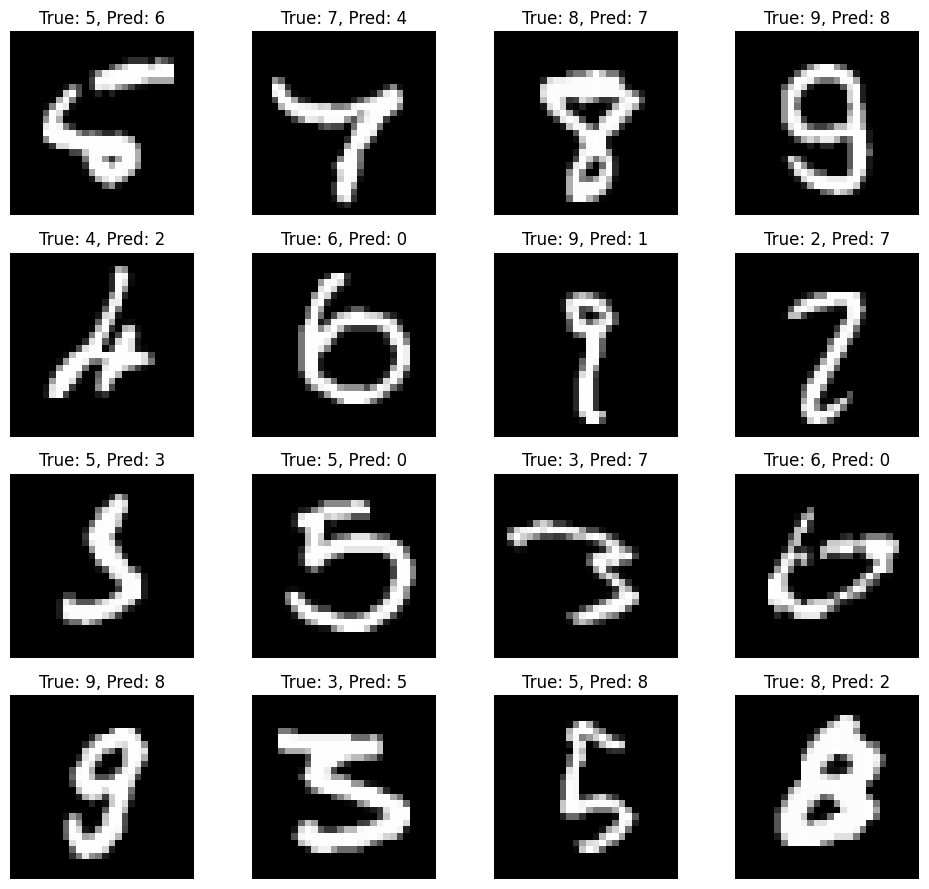

In [48]:
# 14) 오차 분석 테스트 및 시각화 코드
# 모델이 틀리게 예측한 MNIST 이미지 16개가 출력되고, 각 이미지 위에 실제 정답과 예측값이 표시

visualize_misclassified_samples(model, test_dataset_loader)

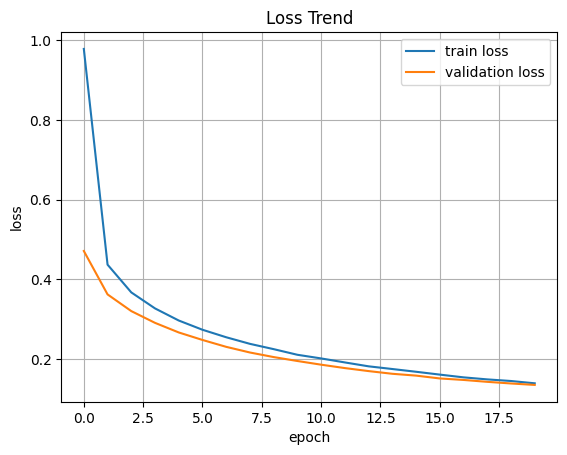

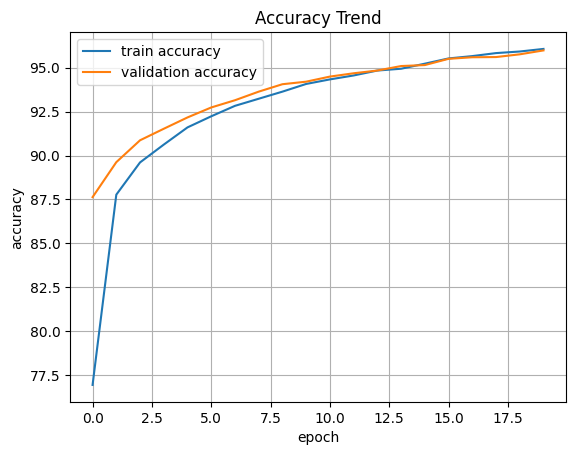

In [ ]:
# 15) 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

In [53]:
# 16) 모델 저장
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_mlp_mnist.ckpt')

In [ ]:
# 17) 테스트 - 모델 추론 및 예측값 추출
model = MLPDeepLearningModel().to(DEVICE)
model.load_state_dict(torch.load('./models/model_mlp_mnist.ckpt'))

BATCH_SIZE = 32

# test dataloader
test_image_loader = DataLoader(dataset=test_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
# test dataset 1개 배치 추출
test_images, test_labels = next(iter(test_image_loader))

# 학습/정답 데이터
x_test = test_images.to(DEVICE)
y_test = test_labels.to(DEVICE)

# 모델 추론
outputs = model(x_test)

# 모델 예측값 추출
_, preds = torch.max(outputs, 1)

{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


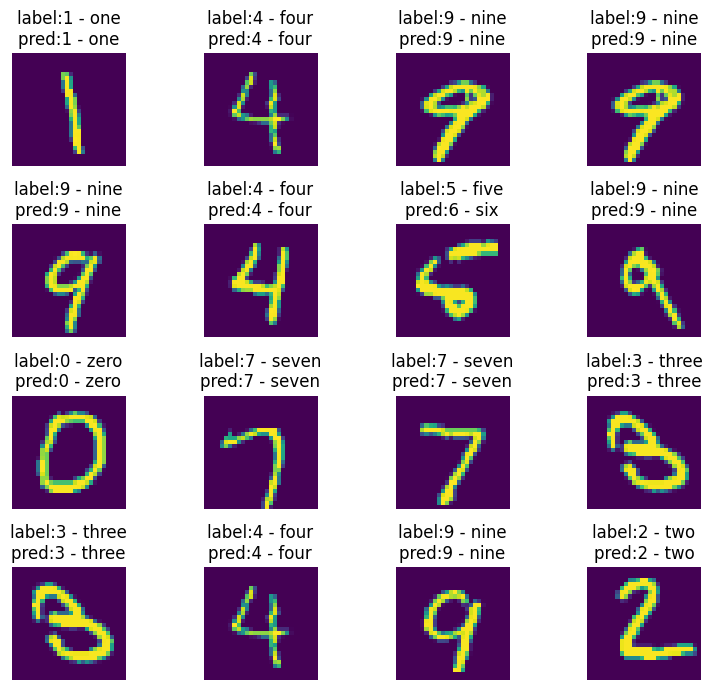

In [ ]:
# 18) 시각화 - 추론 및 정답 비교

# labels map 생성 - train_dataset 에서 정답 label map을 생성
labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

# 시각화
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    plt.subplot(rows, cols, i)

    # torch.randint()를 통한 1개의 index 추출
    sample_idx = torch.randint(len(x_test), size=(1,)).item()
    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()

    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred])
    plt.imshow(torch.permute(img, (1, 2, 0))) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()